In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7f7620f74c6747e3b4aba8faa65182f31ddcc96a23b1b4accac7186ea77d1bcc
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Data Preprocessing

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, month, year, avg

spark = SparkSession.builder \
    .appName("HCHO Trend Analysis") \
    .getOrCreate()

In [ ]:
column_names=["HCHO_Column_Number_Density","City","Start_date","End_date"]

In [ ]:
df_1=pd.read_csv("/content/col_mat_nuw_output.csv",header=None,names=column_names)

In [ ]:
df_1

,HCHO_Column_Number_Density,City,Start_date,End_date
0,0.000197,Colombo Proper,1/1/2019,1/2/2019
1,0.000263,Colombo Proper,1/2/2019,1/3/2019
2,0.000098,Colombo Proper,1/3/2019,1/4/2019
3,0.000210,Colombo Proper,1/4/2019,1/5/2019
4,0.000179,Colombo Proper,1/5/2019,1/6/2019
...,...,...,...,...
5473,NaN,Nuwara Eliya Proper,12/27/2023,12/28/2023
5474,NaN,Nuwara Eliya Proper,12/28/2023,12/29/2023
5475,NaN,Nuwara Eliya Proper,12/29/2023,12/30/2023
5476,NaN,Nuwara Eliya Proper,12/30/2023,12/31/2023


In [ ]:
df_2=pd.read_csv("/content/kan_output.csv",header=None,names=column_names)

In [ ]:
df_2

,HCHO_Column_Number_Density,City,Start_date,End_date
0,0.000176,Kandy Proper,1/1/2019,1/2/2019
1,0.000092,Kandy Proper,1/2/2019,1/3/2019
2,NaN,Kandy Proper,1/3/2019,1/4/2019
3,0.000191,Kandy Proper,1/4/2019,1/5/2019
4,0.000122,Kandy Proper,1/5/2019,1/6/2019
...,...,...,...,...
1821,NaN,Kandy Proper,12/27/2023,12/28/2023
1822,NaN,Kandy Proper,12/28/2023,12/29/2023
1823,NaN,Kandy Proper,12/29/2023,12/30/2023
1824,0.000056,Kandy Proper,12/30/2023,12/31/2023


In [ ]:
df_3=pd.read_csv("/content/mon_kur_jaf_output.csv",header=None,names=column_names)

In [ ]:
df_3

,HCHO_Column_Number_Density,City,Start_date,End_date
0,NaN,"Bibile, Monaragala",1/1/2019,1/2/2019
1,0.000019,"Bibile, Monaragala",1/2/2019,1/3/2019
2,0.000028,"Bibile, Monaragala",1/3/2019,1/4/2019
3,0.000037,"Bibile, Monaragala",1/4/2019,1/5/2019
4,-0.000018,"Bibile, Monaragala",1/5/2019,1/6/2019
...,...,...,...,...
5473,NaN,Jaffna Proper,12/27/2023,12/28/2023
5474,0.000051,Jaffna Proper,12/28/2023,12/29/2023
5475,0.000127,Jaffna Proper,12/29/2023,12/30/2023
5476,0.000117,Jaffna Proper,12/30/2023,12/31/2023


In [ ]:
# Concatenate the DataFrames vertically
df = pd.concat([df_1, df_2, df_3], axis=0)

In [ ]:
df.isnull().sum()

HCHO_Column_Number_Density    4864
City                             0
Start_date                       0
End_date                         0
dtype: int64

In [ ]:
df.shape

(12782, 4)

In [ ]:
df.to_csv('HCHO_Emissions_Data_2before_preprocessed.csv', index=False)

In [ ]:
import pandas as pd

# convert 'Start_date' to datetime
df['Start_date'] = pd.to_datetime(df['Start_date'])

# Set 'Start_date' and 'City' as the index of the DataFrame
df.set_index(['Start_date', 'City'], inplace=True)

# Function to calculate the mode
def get_mode(series):
    modes = series.mode()
    if not modes.empty:
        return modes.iloc[0]
    return None

# Calculate the start of the week for each date for grouping purposes
# We create a temporary DataFrame to avoid modifying the original index during groupby
temp_df = df.copy()
temp_df['Week_Start'] = temp_df.index.get_level_values('Start_date').to_period('W').start_time

# Group by 'City' and 'Week_Start', then calculate the mode for each group
weekly_modes = temp_df.groupby([temp_df.index.get_level_values('City'), 'Week_Start'])['HCHO_Column_Number_Density'].apply(get_mode).reset_index(name='Mode')

# Merge the mode values back into the original DataFrame
df.reset_index(inplace=True)
df = df.merge(weekly_modes, left_on=['City', 'Start_date'], right_on=['City', 'Week_Start'], how='left')

# Fill missing values with the mode values from the same city and week
df['HCHO_Column_Number_Density'] = df['HCHO_Column_Number_Density'].fillna(df['Mode'])

# Drop the temporary 'Week_Start' and 'Mode' columns as they are no longer needed
df.drop(columns=['Week_Start', 'Mode'], inplace=True)

print(df.head())


  Start_date            City  HCHO_Column_Number_Density  End_date
0 2019-01-01  Colombo Proper                    0.000197  1/2/2019
1 2019-01-02  Colombo Proper                    0.000263  1/3/2019
2 2019-01-03  Colombo Proper                    0.000098  1/4/2019
3 2019-01-04  Colombo Proper                    0.000210  1/5/2019
4 2019-01-05  Colombo Proper                    0.000179  1/6/2019


In [ ]:
df.to_csv('HCHO_Emissions_Data_after_handling_null_values.csv', index=False)

In [ ]:

df.reset_index(inplace=True)
df.set_index('Start_date', inplace=True)

# Perform time-based interpolation
df['HCHO_Column_Number_Density'] = df['HCHO_Column_Number_Density'].interpolate(method='time')


df.reset_index(inplace=True)

In [ ]:
df.isnull().sum()

Start_date                    0
index                         0
City                          0
HCHO_Column_Number_Density    0
End_date                      0
dtype: int64

<Axes: xlabel='HCHO_Column_Number_Density'>

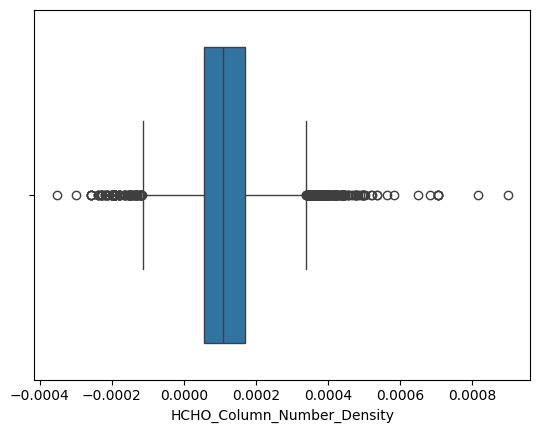

In [ ]:
sns.boxplot(x=df['HCHO_Column_Number_Density'])

In [ ]:
# Calculate Q1, Q3, and IQR
Q1 = df["HCHO_Column_Number_Density"].quantile(0.25)
Q3 = df["HCHO_Column_Number_Density"].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
outliers = df["HCHO_Column_Number_Density"][(df["HCHO_Column_Number_Density"] < (Q1 - 1.5 * IQR)) | (df["HCHO_Column_Number_Density"] > (Q3 + 1.5 * IQR))]

# Get the count of outliers
outlier_count = outliers.shape[0]

print(f"Number of outliers: {outlier_count}")


Number of outliers: 385


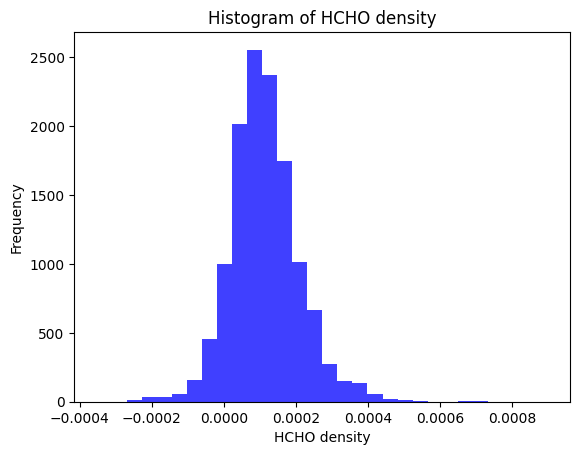

In [ ]:
# Creating the histogram
plt.hist(df['HCHO_Column_Number_Density'], bins=30, alpha=0.75, color='blue')

# Adding title and labels
plt.title('Histogram of HCHO density')
plt.xlabel('HCHO density')
plt.ylabel('Frequency')

# Show the plot
plt.show()

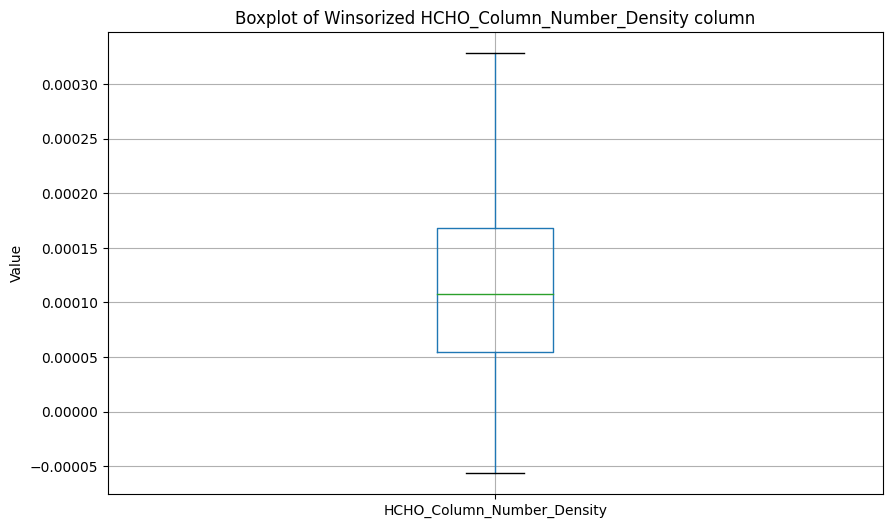

In [ ]:
# Winsorization of 'HCHO_Column_Number_Density' column
df['HCHO_Column_Number_Density'] = winsorize(df['HCHO_Column_Number_Density'], limits=[0.025, 0.025])
plt.figure(figsize=(10, 6))
pd.DataFrame(df['HCHO_Column_Number_Density']).boxplot()
plt.title('Boxplot of Winsorized HCHO_Column_Number_Density column')
plt.ylabel('Value')
plt.show()

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(12782, 5)

In [ ]:
df["City"].value_counts()

City
Colombo Proper         1826
Deniyaya, Matara       1826
Nuwara Eliya Proper    1826
Kandy Proper           1826
Bibile, Monaragala     1826
Kurunegala Proper      1826
Jaffna Proper          1826
Name: count, dtype: int64

In [ ]:
df.dtypes

Start_date                    datetime64[ns]
index                                  int64
City                                  object
HCHO_Column_Number_Density           float64
End_date                              object
dtype: object

In [ ]:
df['Start_date'] = pd.to_datetime(df['Start_date'])
df['End_date'] = pd.to_datetime(df['End_date'])

In [ ]:
# Check the data types again to confirm the change
print(df.dtypes)

Start_date                    datetime64[ns]
index                                  int64
City                                  object
HCHO_Column_Number_Density           float64
End_date                      datetime64[ns]
dtype: object


In [ ]:
df.head()

,Start_date,index,City,HCHO_Column_Number_Density,End_date
0,2019-01-01,0,Colombo Proper,0.000197,2019-01-02
1,2019-01-02,1,Colombo Proper,0.000263,2019-01-03
2,2019-01-03,2,Colombo Proper,0.000098,2019-01-04
3,2019-01-04,3,Colombo Proper,0.000210,2019-01-05
4,2019-01-05,4,Colombo Proper,0.000179,2019-01-06


In [ ]:
df.to_csv('HCHO_Emissions_Data_with_cities.csv', index=False)

In [ ]:
df['City'] = pd.factorize(df['City'])[0]

In [ ]:
df

,Start_date,index,City,HCHO_Column_Number_Density,End_date
0,2019-01-01,0,0,0.000197,2019-01-02
1,2019-01-02,1,0,0.000263,2019-01-03
2,2019-01-03,2,0,0.000098,2019-01-04
3,2019-01-04,3,0,0.000210,2019-01-05
4,2019-01-05,4,0,0.000179,2019-01-06
...,...,...,...,...,...
12777,2023-12-27,12777,6,0.000118,2023-12-28
12778,2023-12-28,12778,6,0.000051,2023-12-29
12779,2023-12-29,12779,6,0.000127,2023-12-30
12780,2023-12-30,12780,6,0.000117,2023-12-31


***Statistical Analysis of HCHO Emissions: Mean, Median, and Standard Deviation in each city***

In [ ]:
# Calculate descriptive statistics
summary_stats = df.groupby('City')['HCHO_Column_Number_Density'].agg(['mean', 'median', 'std'])
summary_stats

,mean,median,std
City,,,
0,0.000144,0.000137,0.000092
1,0.000101,0.000091,0.000086
2,0.000098,0.000090,0.000086
3,0.000106,0.000103,0.000088
4,0.000119,0.000116,0.000089
5,0.000124,0.000118,0.000085
6,0.000108,0.000102,0.000075


***Statistical Analysis of HCHO Emissions: Mean, Median, and Standard Deviation in the entire dataset***

In [ ]:
# Get statistics for the entire dataset
overall_stats = df['HCHO_Column_Number_Density'].agg(['mean', 'median', 'std'])
print(overall_stats)

mean      0.000114
median    0.000108
std       0.000087
Name: HCHO_Column_Number_Density, dtype: float64


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


***HCHO levels as a distribution***

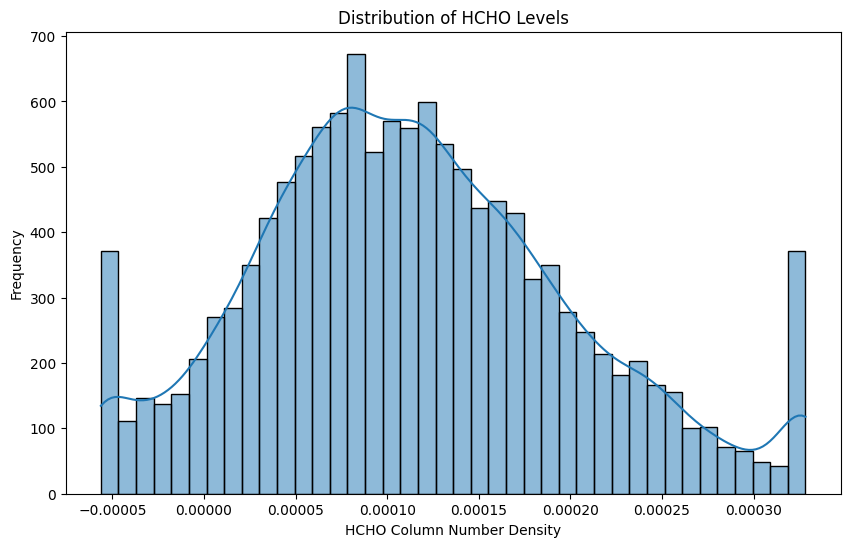

In [ ]:
# Histogram for the entire dataset
plt.figure(figsize=(10, 6))
sns.histplot(df['HCHO_Column_Number_Density'], kde=True)
plt.title('Distribution of HCHO Levels')
plt.xlabel('HCHO Column Number Density')
plt.ylabel('Frequency')
plt.show()

***HCHO levels by city***

# Spatio-Temporal Analysis

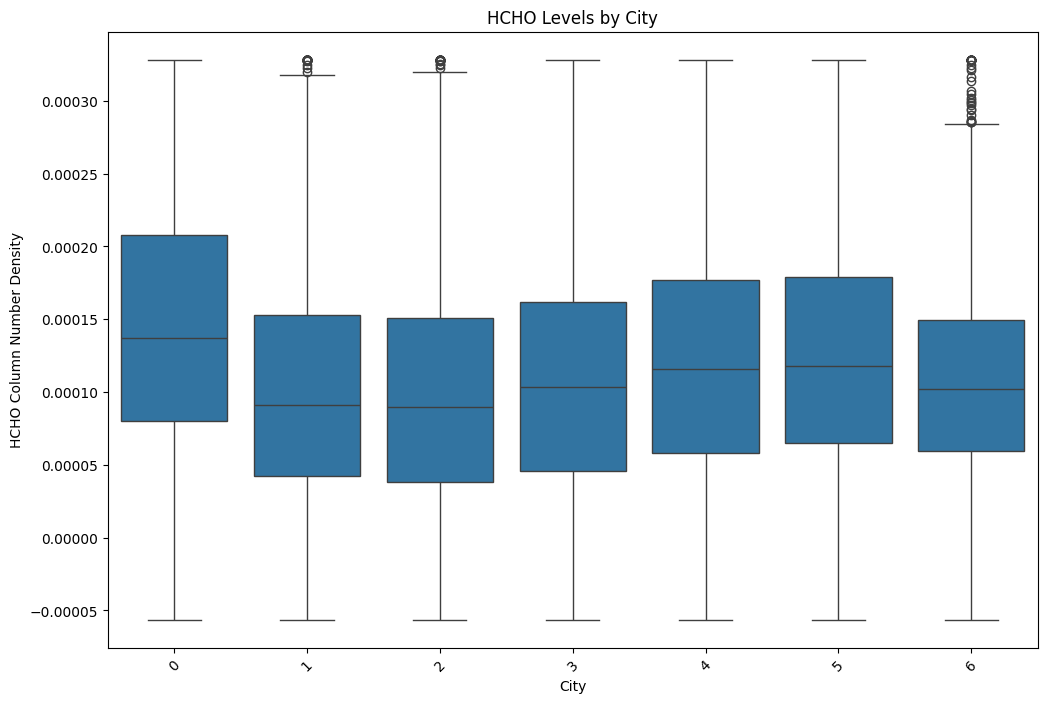

In [ ]:
#Compare the HCHO level distributions across different cities
plt.figure(figsize=(12, 8))
sns.boxplot(x='City', y='HCHO_Column_Number_Density', data=df)
plt.xticks(rotation=45) # Rotating city names for better readability
plt.title('HCHO Levels by City')
plt.xlabel('City')
plt.ylabel('HCHO Column Number Density')
plt.show()


In [ ]:
spark_df = spark.createDataFrame(df)

In [ ]:
# Convert the 'Start_date' to a date type (if not already)
spark_df = spark_df.withColumn("Start_date", to_date(col("Start_date")))
# Select necessary columns and possibly rename for convenience
df_selected = spark_df.select(col("HCHO_Column_Number_Density"), col("City"), col("Start_date"))

In [ ]:
monthly_avg = df_selected.withColumn("Year", year(col("Start_date"))) \
                .withColumn("Month", month(col("Start_date"))) \
                .groupBy("City", "Year", "Month") \
                .agg(avg("HCHO_Column_Number_Density").alias("Monthly_Avg_HCHO")) \
                .orderBy("City", "Year", "Month")
monthly_avg.show()

+----+----+-----+--------------------+
|City|Year|Month|    Monthly_Avg_HCHO|
+----+----+-----+--------------------+
|   0|2019|    1|1.822133548387097...|
|   0|2019|    2|2.301988214285714E-4|
|   0|2019|    3| 2.30351870967742E-4|
|   0|2019|    4|1.593521000000000...|
|   0|2019|    5|1.238972258064516E-4|
|   0|2019|    6|1.226860333333333...|
|   0|2019|    7| 8.72607741935484E-5|
|   0|2019|    8|7.866248387096773E-5|
|   0|2019|    9|9.564896666666667E-5|
|   0|2019|   10|1.448573387096774E-4|
|   0|2019|   11|1.541804666666666...|
|   0|2019|   12|1.448280161290322...|
|   0|2020|    1|1.990857096774193...|
|   0|2020|    2|2.399025172413793...|
|   0|2020|    3|2.428242258064515...|
|   0|2020|    4|1.545880666666666...|
|   0|2020|    5|1.448879677419355E-4|
|   0|2020|    6|8.835360000000001E-5|
|   0|2020|    7|1.156391290322580...|
|   0|2020|    8|7.765609677419355E-5|
+----+----+-----+--------------------+
only showing top 20 rows



In [ ]:
monthly_avg_pandas = monthly_avg.toPandas()

***Monthly Average HCHO Levels by City***

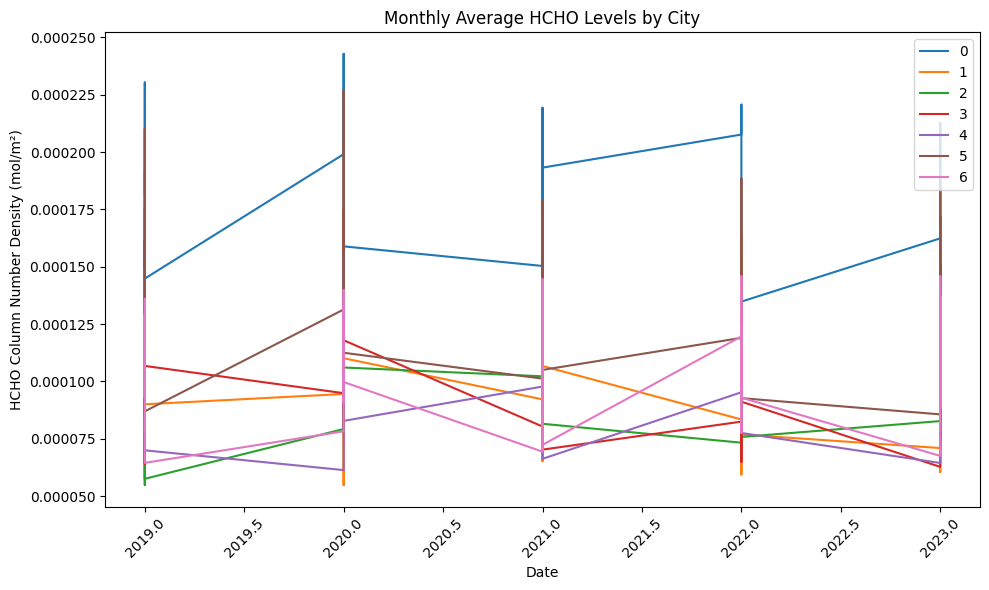

In [ ]:
# Plotting monthly HCHO levels for each city
fig, ax = plt.subplots(figsize=(10, 6))

for city in monthly_avg_pandas['City'].unique():
    city_data = monthly_avg_pandas[monthly_avg_pandas['City'] == city]
    ax.plot(city_data['Year'], city_data['Monthly_Avg_HCHO'], label=city)

ax.set_xlabel('Date')
ax.set_ylabel('HCHO Column Number Density (mol/m²)')
ax.set_title('Monthly Average HCHO Levels by City')
plt.xticks(rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


<ipython-input-137-f0fdb0eb48f3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['Date'] = pd.to_datetime(city_data['Year'].astype(str) + '-' + city_data['Month'].astype(str))
<ipython-input-137-f0fdb0eb48f3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data['Date'] = pd.to_datetime(city_data['Year'].astype(str) + '-' + city_data['Month'].astype(str))
<ipython-input-137-f0fdb0eb48f3>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

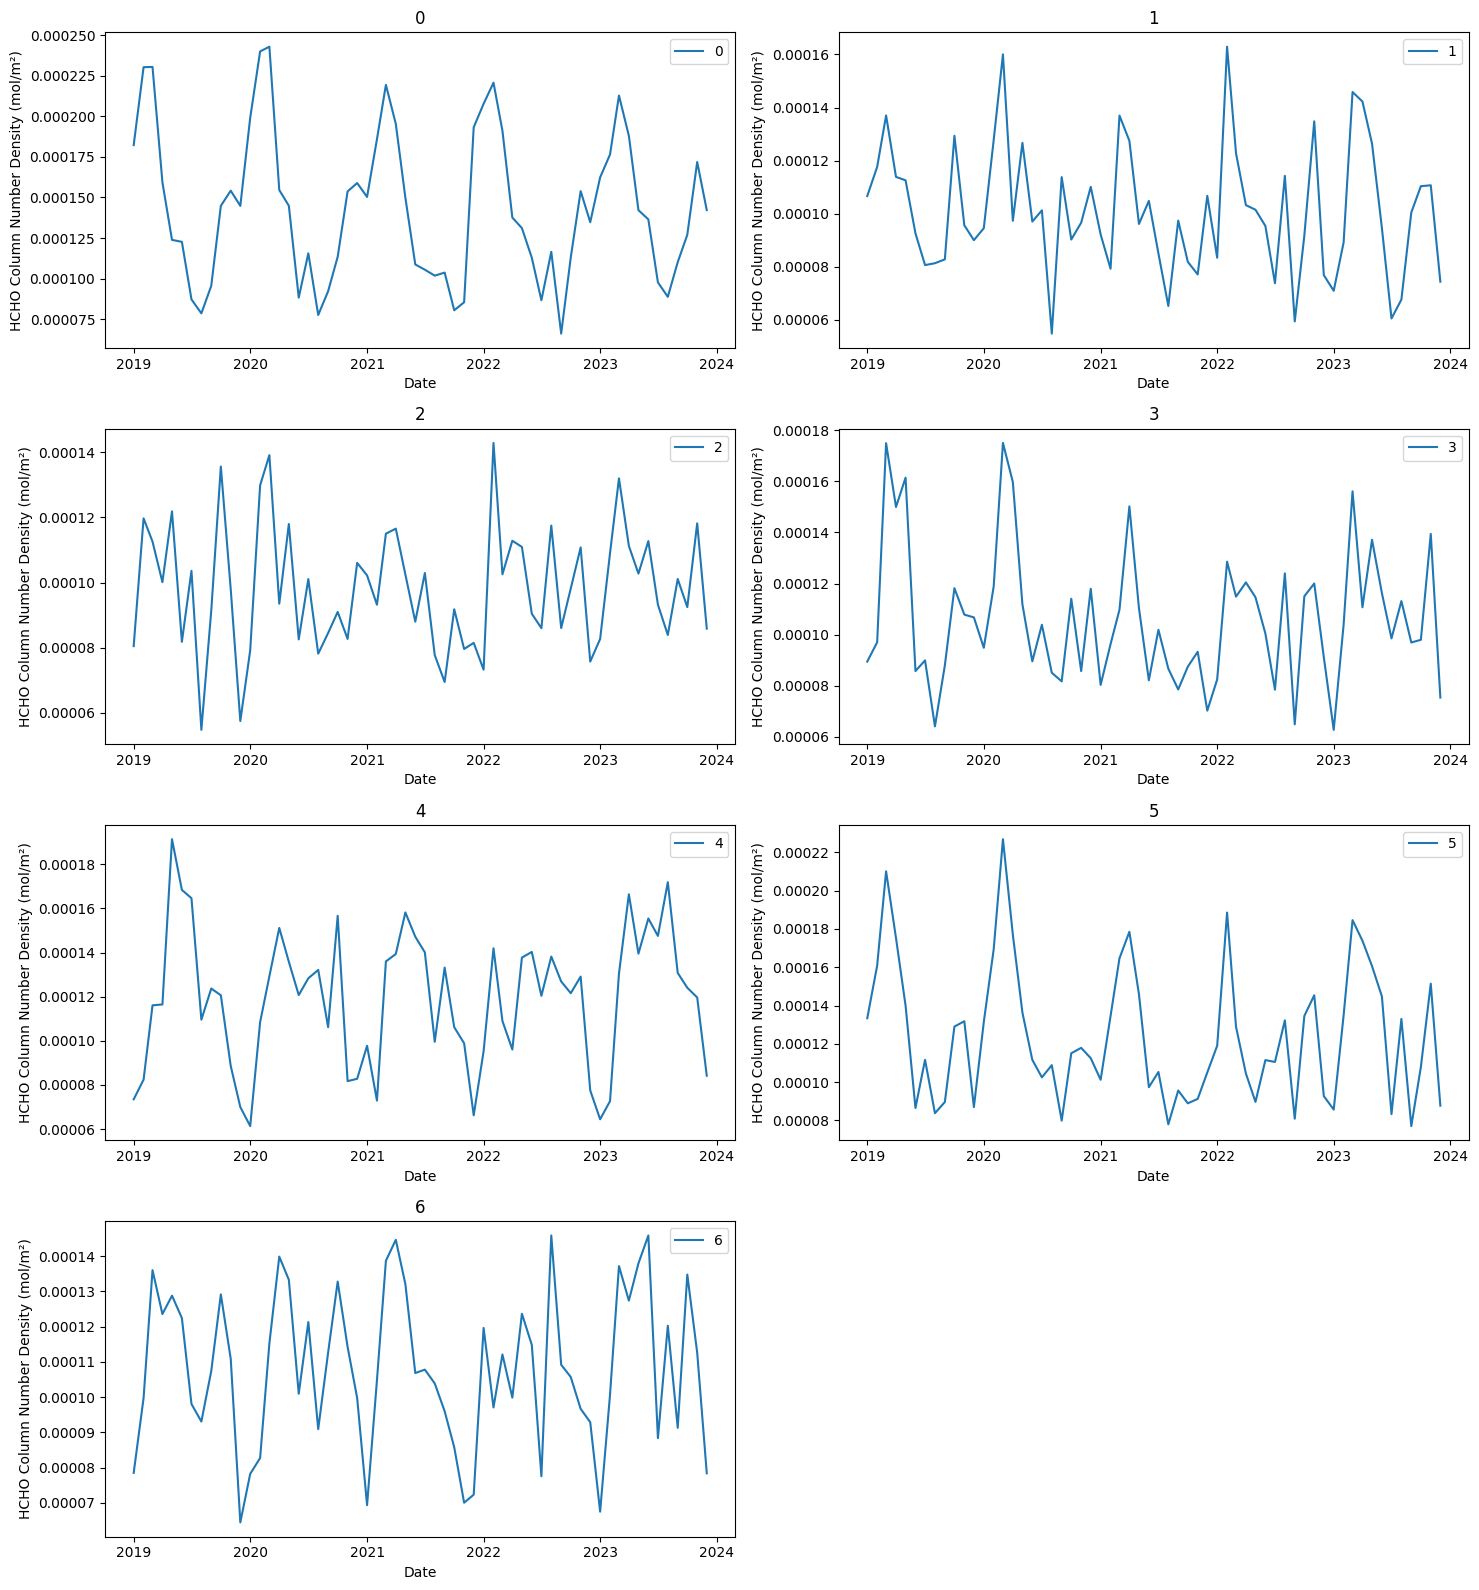

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
# Get a list of unique cities
cities = monthly_avg_pandas['City'].unique()

# Determine the layout of the subplots
n = len(cities)  # Number of cities
ncols = 2  # Number of columns in subplot grid
nrows = n // ncols + (n % ncols > 0)  # Number of rows in subplot grid

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, nrows*4), squeeze=False)
axes = axes.flatten()  # Flatten the array to make indexing easier

for i, city in enumerate(cities):
    # Filter the DataFrame for the current city
    city_data = monthly_avg_pandas[monthly_avg_pandas['City'] == city]

    # For plotting, create a 'Date' column that combines 'Year' and 'Month'
    city_data['Date'] = pd.to_datetime(city_data['Year'].astype(str) + '-' + city_data['Month'].astype(str))

    # Plot data for the city
    axes[i].plot(city_data['Date'], city_data['Monthly_Avg_HCHO'], label=city)

    # Set subplot title and labels
    axes[i].set_title(city)
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('HCHO Column Number Density (mol/m²)')
    axes[i].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# If there are any leftover axes, turn them off
for j in range(i+1, nrows*ncols):
    fig.delaxes(axes[j])

plt.show()


Monthly HCHO Emissions Across All Cities

<ipython-input-138-7d2b59827e99>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data_year['Date'] = pd.to_datetime(city_data_year['Year'].astype(str) + '-' + city_data_year['Month'].astype(str))
<ipython-input-138-7d2b59827e99>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_data_year['Date'] = pd.to_datetime(city_data_year['Year'].astype(str) + '-' + city_data_year['Month'].astype(str))
<ipython-input-138-7d2b59827e99>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

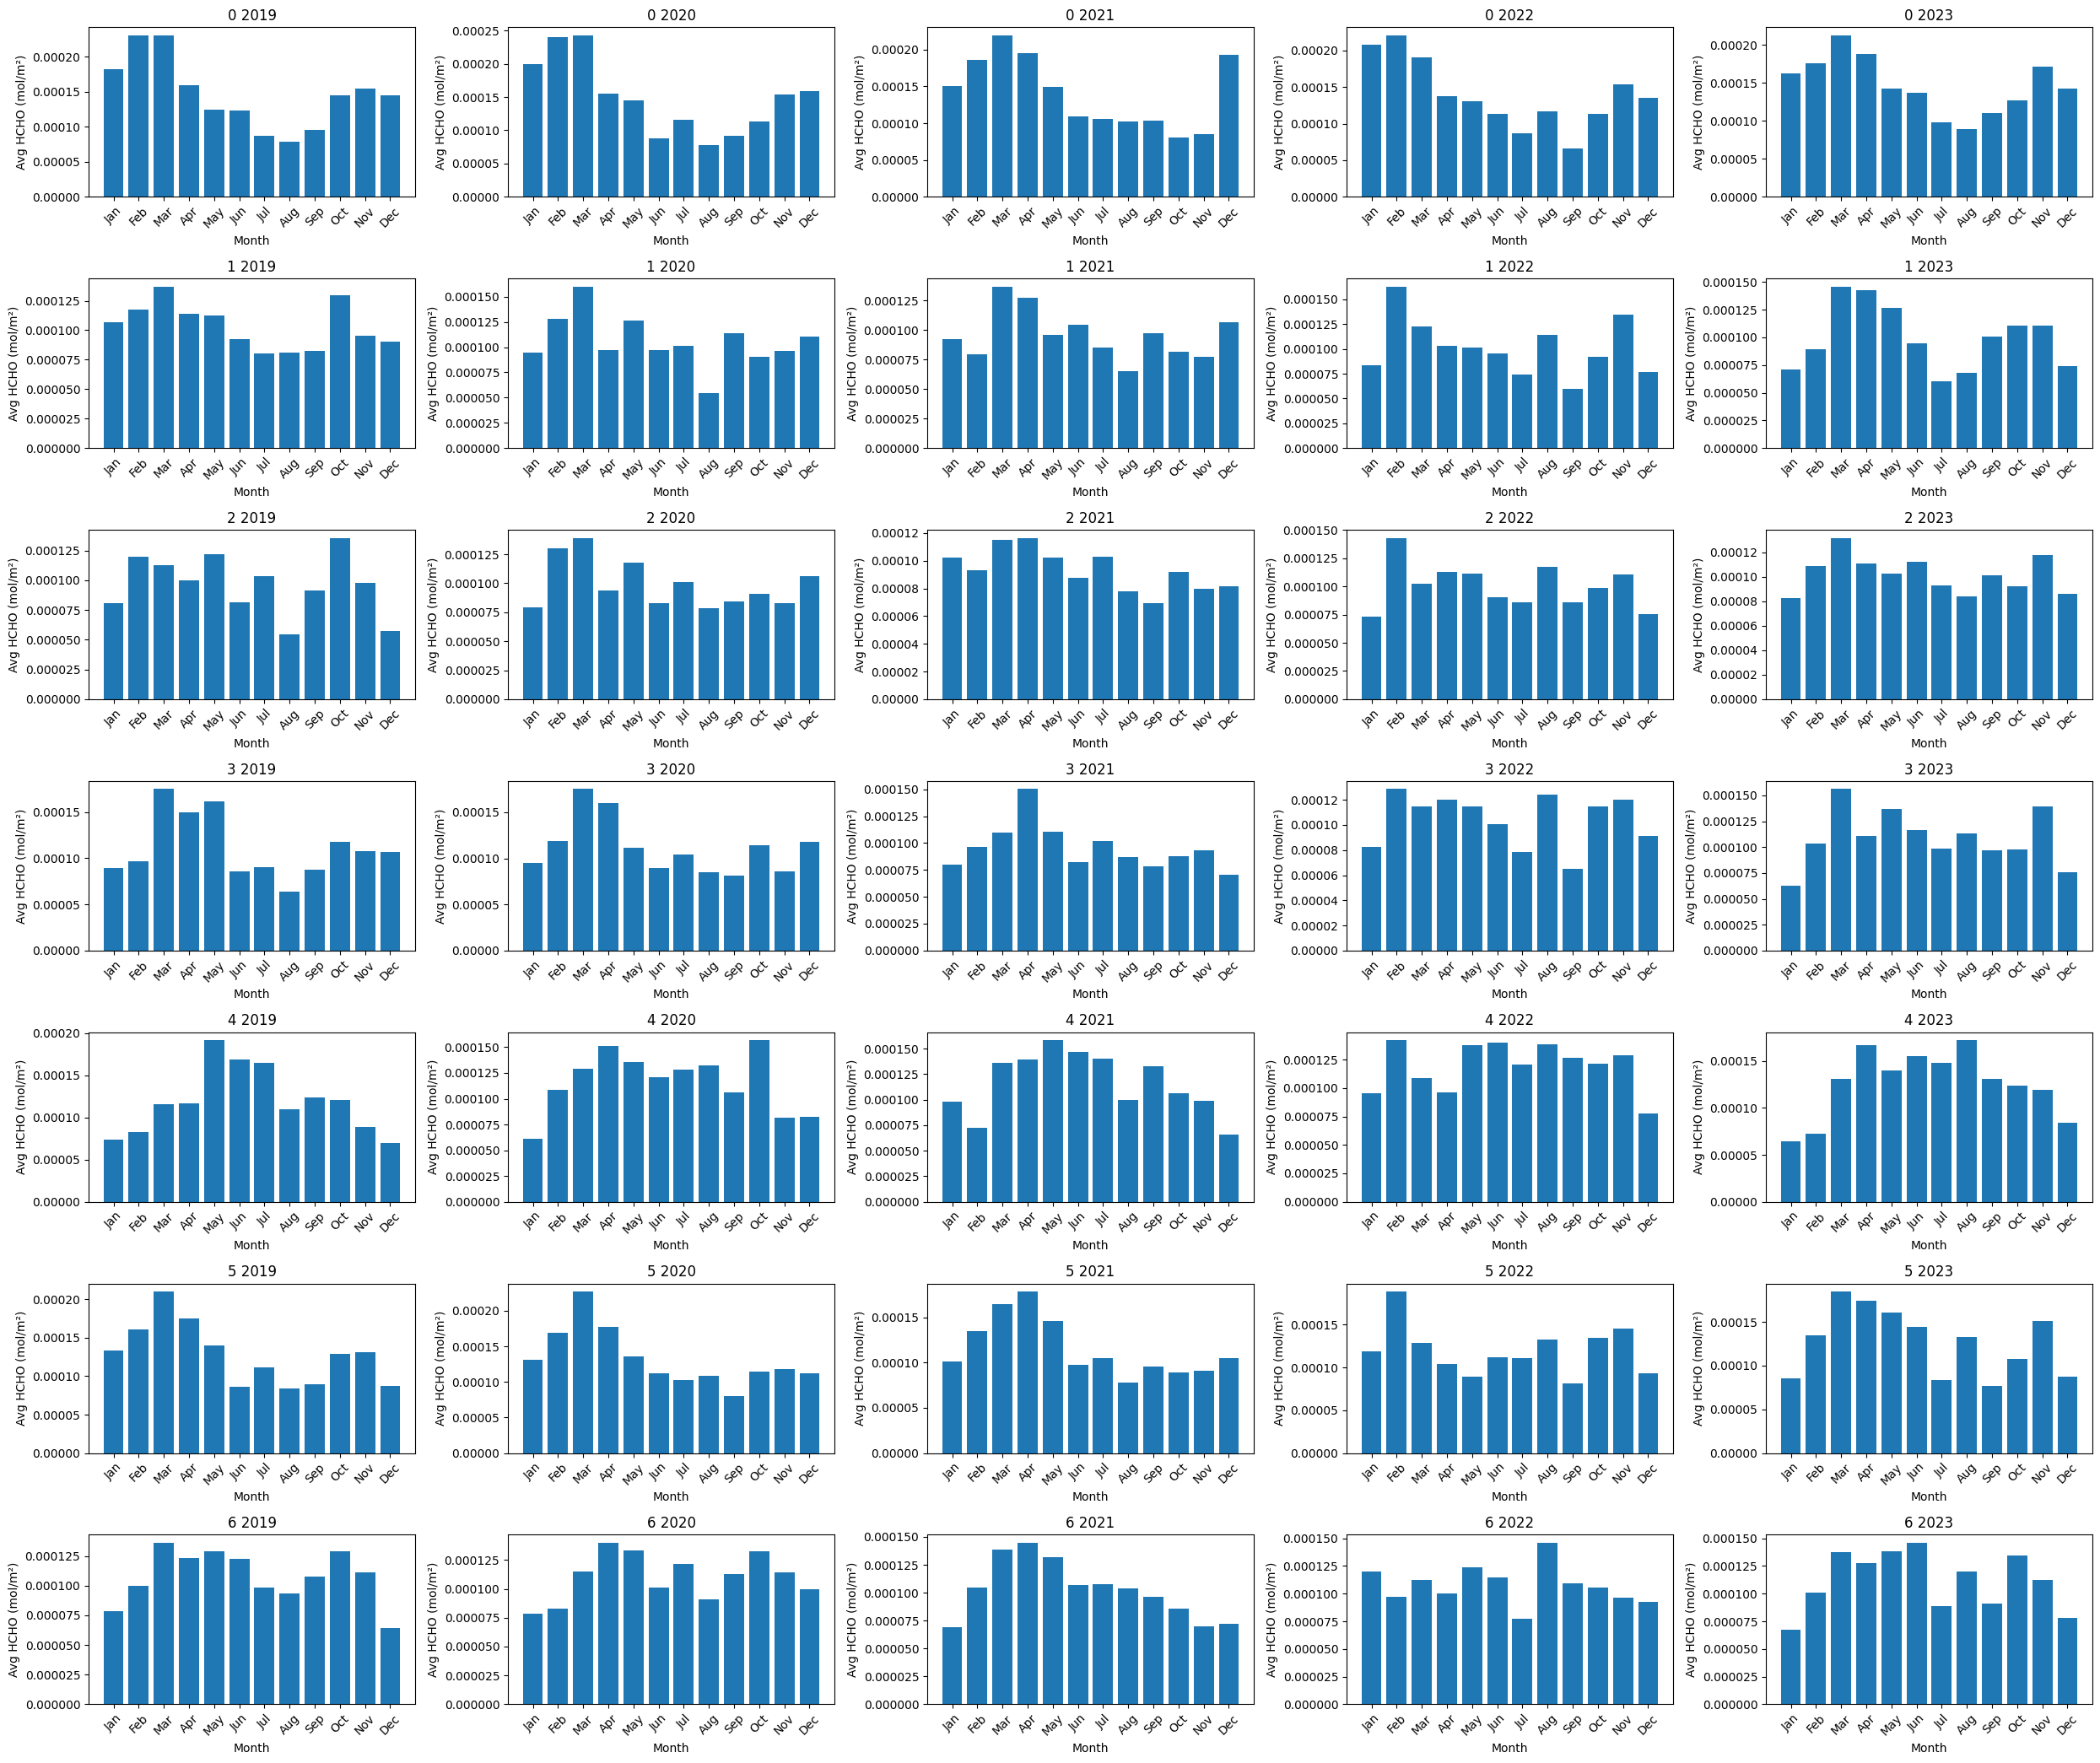

In [ ]:
def plot_monthly_hcho_emission_in_all_cities(start_year=2019, end_year=2023):
    cities = monthly_avg_pandas['City'].unique()
    n_cities = len(cities)
    years = list(range(start_year, end_year + 1))
    n_years = len(years)

    # Calculate the layout of the subplots
    nrows = n_cities  # One row for each city
    ncols = n_years  # One column for each year

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 3*nrows), squeeze=False)

    for i, city in enumerate(cities):
        for j, year in enumerate(years):
            city_data_year = monthly_avg_pandas[(monthly_avg_pandas['City'] == city) & (monthly_avg_pandas['Year'] == year)]

            # For plotting, create a 'Date' column that combines 'Year' and 'Month'
            city_data_year['Date'] = pd.to_datetime(city_data_year['Year'].astype(str) + '-' + city_data_year['Month'].astype(str))

            # Group by month and calculate average HCHO values
            monthly_avg = city_data_year.groupby(city_data_year['Date'].dt.month)['Monthly_Avg_HCHO'].mean()

            # Plot data for the city for each month in year
            axes[i, j].bar(monthly_avg.index, monthly_avg.values)
            axes[i, j].set_title(f'{city} {year}')
            axes[i, j].set_xticks(range(1, 13))
            axes[i, j].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
            axes[i, j].set_xlabel('Month')
            axes[i, j].set_ylabel('Avg HCHO (mol/m²)')

    plt.tight_layout()
    plt.show()

# Assuming 'monthly_avg_pandas' is your DataFrame and it has the necessary data
# Call the function
plot_monthly_hcho_emission_in_all_cities()


***Seasonal variations and trends***

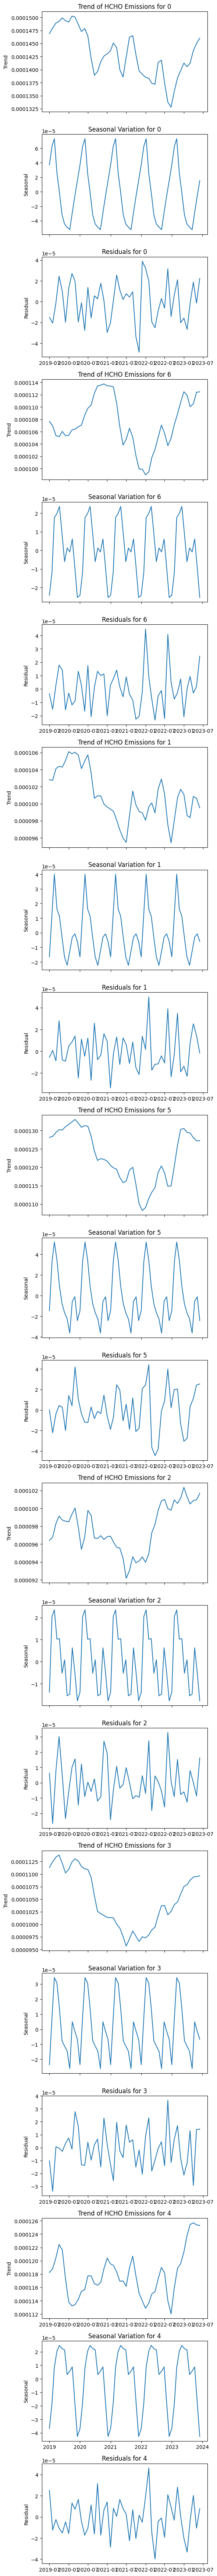

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_variation_of_all_cities(indices):
    # Ensure the data is sorted by date if it isn't already
    monthly_avg_pandas['Date'] = pd.to_datetime(monthly_avg_pandas['Year'].astype(str) + '-' + monthly_avg_pandas['Month'].astype(str), format='%Y-%m')
    monthly_avg_pandas_sorted = monthly_avg_pandas.sort_values(by='Date')

    # Setting the figure size and layout for subplots
    # Multiplying by 3 as we want to plot trend, seasonal, and residual components separately
    fig, axes = plt.subplots(nrows=len(indices) * 3, ncols=1, figsize=(6, 10 * len(indices)))

    for i, num in enumerate(indices):
        city_name = monthly_avg_pandas_sorted['City'].unique()[num]
        city_data = monthly_avg_pandas_sorted[monthly_avg_pandas_sorted['City'] == city_name]

        # Ensure there's one value per month by averaging in case of duplicates
        city_data_monthly_avg = city_data.groupby('Date')['Monthly_Avg_HCHO'].mean()

        # Decomposing the time series
        result = seasonal_decompose(city_data_monthly_avg, model='additive', period=12)

        # Plotting the decomposed components manually
        # Trend
        ax_trend = axes[i * 3]
        ax_trend.plot(result.trend)
        ax_trend.set_title(f'Trend of HCHO Emissions for {city_name}')
        ax_trend.set_ylabel('Trend')

        # Seasonal
        ax_seasonal = axes[i * 3 + 1]
        ax_seasonal.plot(result.seasonal)
        ax_seasonal.set_title(f'Seasonal Variation for {city_name}')
        ax_seasonal.set_ylabel('Seasonal')

        # Residual
        ax_residual = axes[i * 3 + 2]
        ax_residual.plot(result.resid)
        ax_residual.set_title(f'Residuals for {city_name}')
        ax_residual.set_ylabel('Residual')

        # Hide x labels and titles for all but the last set for clarity
        if i < len(indices) - 1:
            plt.setp(ax_trend.get_xticklabels(), visible=False)
            plt.setp(ax_seasonal.get_xticklabels(), visible=False)
            ax_trend.set_xlabel('')
            ax_seasonal.set_xlabel('')

    plt.tight_layout()
    plt.show()

# Make sure your monthly_avg_pandas DataFrame is correctly defined before calling this function
# Example usage with indices 0,1,2,3,4,5,6 to plot for all cities
seasonal_variation_of_all_cities([0, 1, 2, 3, 4, 5, 6])


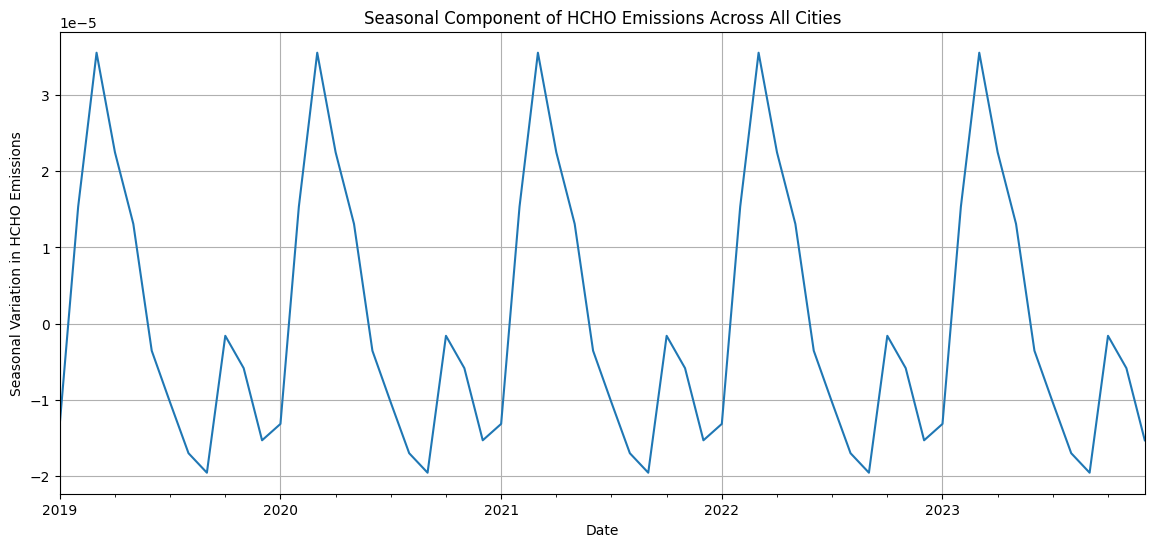

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose


monthly_avg_pandas['Date'] = pd.to_datetime(monthly_avg_pandas['Year'].astype(str) + '-' + monthly_avg_pandas['Month'].astype(str), format='%Y-%m')
monthly_avg_pandas_sorted = monthly_avg_pandas.sort_values(by='Date')

# Aggregating the data across all cities for each month
all_cities_monthly_avg = monthly_avg_pandas_sorted.groupby('Date')['Monthly_Avg_HCHO'].mean()

# Decomposing the time series
decompose_result = seasonal_decompose(all_cities_monthly_avg, model='additive', period=12)

# Extracting the seasonal component
seasonal_component = decompose_result.seasonal

# Plotting the seasonal component to visualize seasonal variations across all cities
plt.figure(figsize=(14, 6))
seasonal_component.plot()
plt.title('Seasonal Component of HCHO Emissions Across All Cities')
plt.xlabel('Date')
plt.ylabel('Seasonal Variation in HCHO Emissions')
plt.grid(True)
plt.show()


***Analyzing long term trends***

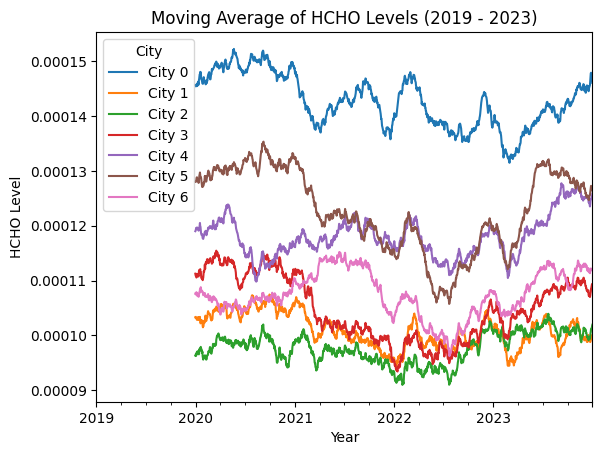

In [ ]:
df_indexed= df.copy()
df_indexed.set_index('Start_date', inplace=True)
df_pivot = df_indexed.pivot(columns='City', values='HCHO_Column_Number_Density')

# Calculate the rolling average for each city label and plot
window_size = 365  # Number of days over which to calculate the mean
for city_label in df_pivot.columns:
    rolling_avg = df_pivot[city_label].rolling(window=window_size).mean()
    rolling_avg.plot(label=f'City {city_label}')

plt.title('Moving Average of HCHO Levels (2019 - 2023)')
plt.xlabel('Year')
plt.ylabel('HCHO Level')

plt.legend(title='City')
plt.show()

***Identifing changes in gas emissions due to the COVID-19 lockdowns***

In [ ]:
# Define the lockdown start and end dates
# Adjust these dates to fit the actual lockdown timeline
lockdown_start = pd.Timestamp('2020-04-20')
lockdown_end = pd.Timestamp('2020-09-30')

# Filter data into three periods: pre-lockdown, during lockdown, and post-lockdown
# Filter data into three periods
pre_lockdown = df_indexed[df_indexed.index < lockdown_start]
during_lockdown = df_indexed[(df_indexed.index >= lockdown_start) & (df_indexed.index <= lockdown_end)]
post_lockdown = df_indexed[df_indexed.index > lockdown_end]


# Compute average HCHO_Column_Number_Density for each period by location
average_pre_lockdown = pre_lockdown.groupby('City')['HCHO_Column_Number_Density'].mean()
average_during_lockdown = during_lockdown.groupby('City')['HCHO_Column_Number_Density'].mean()
average_post_lockdown = post_lockdown.groupby('City')['HCHO_Column_Number_Density'].mean()

# Create a DataFrame to compare these averages
comparisons = pd.DataFrame({
    'Pre-Lockdown': average_pre_lockdown,
    'During Lockdown': average_during_lockdown,
    'Post-Lockdown': average_post_lockdown
})



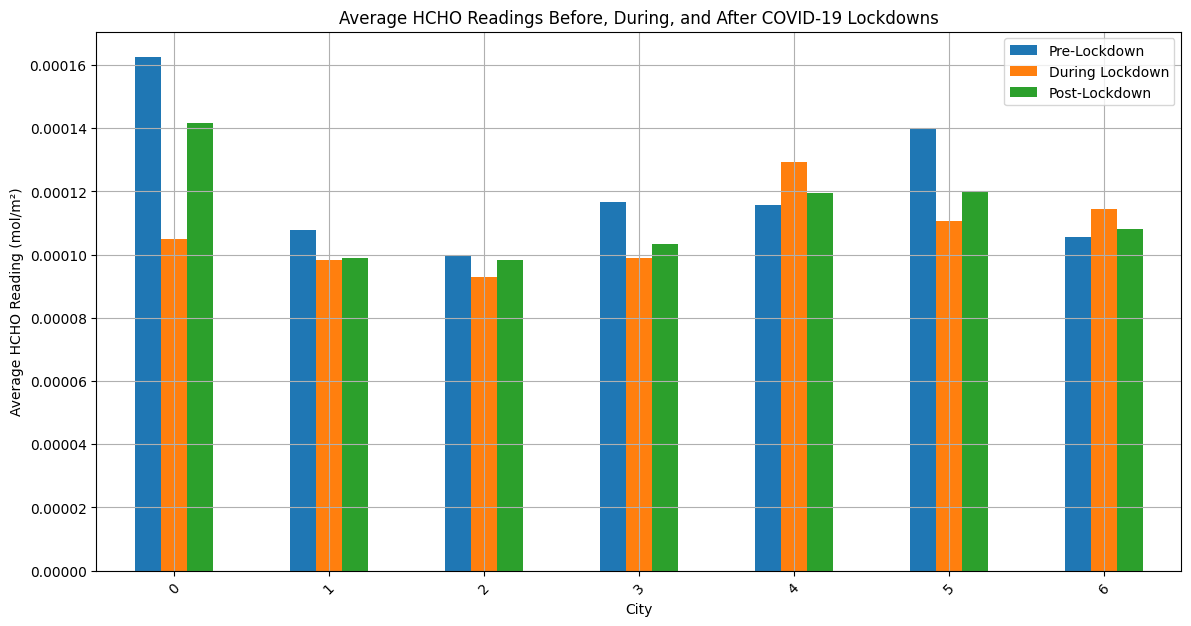

In [ ]:
# Plotting the comparison as bar charts for each city
ax = comparisons.plot(kind='bar', figsize=(14, 7), title='Average HCHO Readings Before, During, and After COVID-19 Lockdowns')
ax.set_ylabel('Average HCHO Reading (mol/m²)')
ax.set_xlabel('City')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [ ]:
df.to_csv('HCHO_Emissions_Data.csv', index=False)
